<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning with Python</h1>
<h2 align="center" style="margin-top:20px">Lecture 6: Nonlinear Modelling</h2>
<br>

In this notebook we study how to use regression splines, local regression, and generalised additive models in Python.

<a class="buttom" href="#1.-Customer-Analytics-Data">Customer Analytics Data</a> <br>
<a class="buttom" href="#2.-Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a class="buttom" href="#3.-Regression-Splines">Regression Splines</a> <br>
<a class="buttom" href="#4.-Natural-Splines">Natural Splines</a> <br>
<a class="buttom" href="#5.-Local-Regression">Local Regression</a> <br>
<a class="buttom" href="#6.-Generalised-Additive-Modelling">Generalised Additive Modelling</a> <br>
<a class="buttom" href="#7.-Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following imports and settings.

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

### 1. Customer Analytics Data 

The dataset for this notebook is based on customer analytics.  The objective of this type of analysis is to predict the profitability of a customer, which involves both classification and regression tasks. We apply classification methods to predict whether a customer will be acquired and retained, and regression methods to estimate the profitability of acquired and retained customers.

Here, we focus on the regression task, though a more complete model can include all parts of the customer cycle. In particular, we will predict the customer lifetime value (CLV, a measure of profitability), taking into account some of the nonlinearities in the data.

In [4]:
data = pd.read_excel('Data/CustomerAcquisition.xls', index_col=[0])
data.head(10)

,Acquisition,First_Purchase,CLV,Duration,Censor,Acq_Expense,Acq_Expense_SQ,Industry,Revenue,Employees,Ret_Expense,Ret_Expense_SQ,Crossbuy,Frequency,Frequency_SQ
Customer,,,,,,,,,,,,,,,
1,1,433.64,0.0000,384,0,760.36,578147.33,1,30.16,1240,2309.79,5335129.84,5,2,4
2,0,0.00,0.0000,0,0,147.70,21815.29,1,39.80,166,0.00,0.00,0,0,0
3,0,0.00,0.0000,0,0,252.56,63786.55,1,54.93,1016,0.00,0.00,0,0,0
4,1,225.84,5.7316,730,1,609.73,371770.67,1,45.83,122,2192.59,4807450.91,2,12,144
5,1,363.04,0.0000,579,0,672.36,452067.97,1,69.03,313,801.14,641825.30,4,7,49
6,0,0.00,0.0000,0,0,435.57,189721.22,0,22.54,359,0.00,0.00,0,0,0
7,0,0.00,0.0000,0,0,362.90,131696.41,0,32.97,902,0.00,0.00,0,0,0
8,0,0.00,0.0000,0,0,883.54,780642.93,0,22.48,264,0.00,0.00,0,0,0
9,1,599.30,6.9161,730,1,452.35,204620.52,1,17.98,1782,1340.75,1797610.56,1,11,121



The response variable is thus the CLV of customers who were acquired and remained as customers by the end of the observation window (730 days). These customers are identified with a value of one for the `Censor` variable.

In [5]:
data = data[data['Censor']==1] # our goal is to predict the CLV of retained customers, identified by Censor=1 

The predictors are dollars spent on marketing expenses for acquiring and retaining the customer, the value of the first purchase, revenue and number of employees of the customer, the number of product categories the customer purchased, the number of times the customer purchased during the observation window, and industry.

In [6]:
response = ['CLV']
predictors= ['Acq_Expense', 'Ret_Expense', 'First_Purchase', 'Revenue', 'Employees', 
 'Frequency', 'Crossbuy', 'Industry']
    
data = data[response+predictors] # keeping only the variables that we are going to use

As usual, we split the data into training (70%) and test (30%) sets before proceeding. 

In [7]:
from sklearn.model_selection import train_test_split

# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.7, random_state=1)

# Write training and test sets 
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

X_train = train[predictors].to_numpy()
X_test = test[predictors].to_numpy()
y_train= train['CLV'].to_numpy()
y_test= test['CLV'].to_numpy()

## 2. Exploratory Data Analysis

We start by computing the correlations between the response and the predictors. The value of the first purchase is the predictor that has the strongest linear relationship with the CLV.

In [8]:
train.corr().round(3)[['CLV']]

,CLV
CLV,1.000
Acq_Expense,-0.373
Ret_Expense,0.455
First_Purchase,0.581
Revenue,0.085
Employees,0.530
Frequency,-0.067
Crossbuy,0.413
Industry,0.209


To explore possible nonlinearities in the data, we build scatter plots for all the predictors. The scatter plots include local regression fits for visualisation. Nonlinear patterns are apparent for several predictors, in particular the acquisition and retention expenses, customer revenue, and purchasing frequency. 

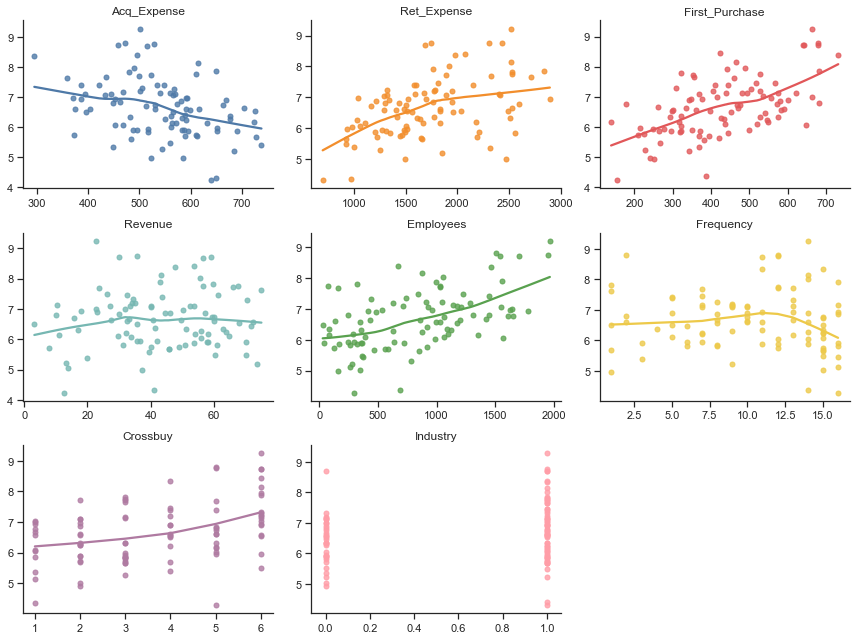

In [9]:
from statlearning import plot_regressions
plot_regressions(train[predictors], y_train, lowess=True)
plt.show()

## 3. Regression Splines

For illustrative purposes, we will focus on a single predictor for this and the following two sections.

Regression splines are not immediately available in Python. Instead, we use the [<TT>patsy</TT>](http://patsy.readthedocs.io/en/latest/index.html) library to construct spline expansions. Our implementation is based on two core functions: [<TT>dmatrix</TT>](http://patsy.readthedocs.io/en/latest/API-reference.html#patsy.dmatrix), the general design matrix constructor, and [<TT>bs</TT>](http://patsy.readthedocs.io/en/latest/API-reference.html#spline-regression), the building block for regression splines.

The next cell builds cubic spline basis expansions for retention expenses variable. We specify that we want the cubic spline by setting `degree=3`. We remove the column of ones from the design matrix because the intercept will be added in at the linear regression fitting stage.  We set the degrees of freedom as `df=4`, which has the effect of setting the number of knots to 1 (recall from the lecture that when the intercept is included, the df is the number of knots plus 4, but we removed the intercept, so df = number of knots + 3 here).

The function below generates so-called B-splines rather than the exact spline functions defined in the lecture. B-splines generate an equivalent model, but have better numerical properties. 

In [10]:
from patsy import dmatrix

X = dmatrix('bs(predictor, degree=3, df=4) - 1', {'predictor': train['Ret_Expense']}, return_type='dataframe')
# The -1 excludes the intercept
X.head()

,"bs(predictor, degree=3, df=4)[0]","bs(predictor, degree=3, df=4)[1]","bs(predictor, degree=3, df=4)[2]","bs(predictor, degree=3, df=4)[3]"
Customer,,,,
350,0.606539,0.280049,0.037076,0.000000
317,0.237217,0.496742,0.265357,0.000684
337,0.140893,0.452204,0.394179,0.012725
467,0.033173,0.250264,0.570477,0.146086
184,0.008891,0.122594,0.533078,0.335436


Given the design matrix, we estimate the model by OLS. 

In [11]:
ols = LinearRegression()
ols.fit(X, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

To plot the estimated model, we first need to construct the features. 

In [12]:
from patsy import build_design_matrices

a=train['Ret_Expense'].min()
b=train['Ret_Expense'].max()
x=np.linspace(a, b)

# remember that X is our original design matrix
X_predict = build_design_matrices([X.design_info], {'predictor': x})[0] 
y_fitted=ols.predict(X_predict)

Finally, we plot the regression fit. 

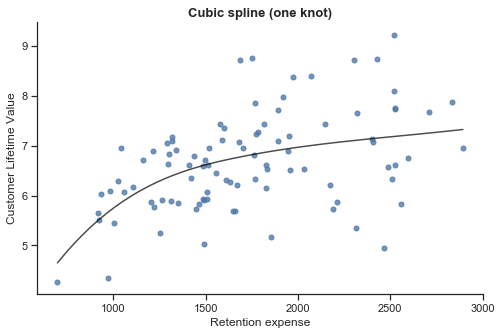

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['Ret_Expense'], y_train,  scatter_kws = {'s': 25}, fit_reg=False)
ax.plot(x, y_fitted, color='Black', alpha=0.7)
ax.set_xlabel('Retention expense')
ax.set_ylabel('Customer Lifetime Value')
ax.set_title('Cubic spline (one knot)', fontsize=13, fontweight='bold')

sns.despine()
plt.show()

The next cell repeats all these steps for a linear spline with two knots. You should experiment by changing the first two lines to try different models (say, by adding more knots and/or changing the polynomial degree) and trying different predictors.

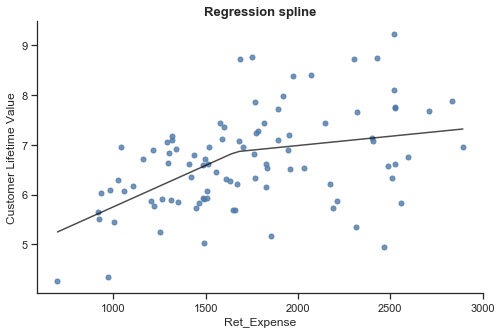

In [14]:
predictor = 'Ret_Expense'
X = dmatrix('bs(variable, degree=1, df=2) - 1', {'variable': train[predictor]}, return_type='dataframe')

ols = LinearRegression()
ols.fit(X, y_train)

a=train[predictor].min()
b=train[predictor].max()
x=np.linspace(a, b)

# remember that X is our original design matrix
X_predict = build_design_matrices([X.design_info], {'variable': x})[0]
y_fitted=ols.predict(X_predict)

fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train[predictor], y_train,  scatter_kws = {'s': 25}, fit_reg=False)
ax.plot(x, y_fitted, color='Black', alpha=0.7)
ax.set_ylabel('Customer Lifetime Value')
ax.set_title('Regression spline', fontsize=13, fontweight='bold')

sns.despine()
plt.show()

## 4. Natural Splines

Estimating a natural cubic spline requires only a minor modification in the code.

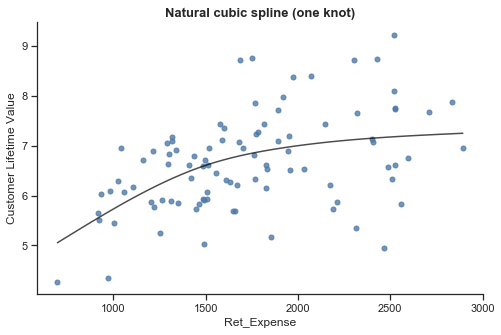

In [15]:
predictor = 'Ret_Expense'
X = dmatrix('cr(variable, df=4) - 1', {'variable': train[predictor]}, return_type='dataframe')

ols = LinearRegression()
ols.fit(X, y_train)

a=train[predictor].min()
b=train[predictor].max()
x=np.linspace(a, b)

X_predict = build_design_matrices([X.design_info], {'variable': x})[0] 
y_fitted=ols.predict(X_predict)

fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train[predictor], y_train,  scatter_kws = {'s': 25}, fit_reg=False)
ax.plot(x, y_fitted, color='Black', alpha=0.7)
ax.set_ylabel('Customer Lifetime Value')
ax.set_title('Natural cubic spline (one knot)', fontsize=13, fontweight='bold')

sns.despine()
plt.show()

### 5. Local Regression

The local regression method in only available in the `statsmodels` package, so that the syntax will look different for this method.  

We do as follows to fit the model.

In [16]:
from statsmodels.nonparametric.kernel_regression import KernelReg
predictor = 'Ret_Expense'
kernel= KernelReg(y_train, train[predictor], var_type='c')

Let's visualise the estimated model.

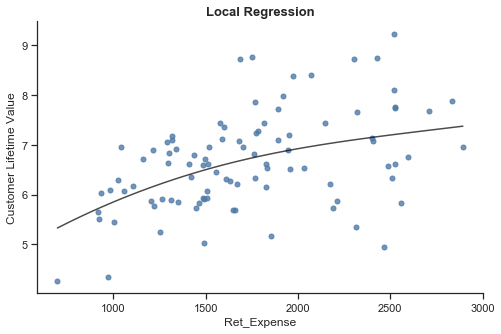

In [17]:
a=train[predictor].min()
b=train[predictor].max()
x=np.linspace(a, b)

y_fitted = kernel.fit(x)[0] #this corresponds to the predict method in other packages 

fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train[predictor], y_train,  scatter_kws = {'s': 25}, fit_reg=False)
ax.plot(x, y_fitted, color='Black', alpha=0.7)
ax.set_ylabel('Customer Lifetime Value')
ax.set_title('Local Regression', fontsize=13, fontweight='bold')

sns.despine()
plt.show()

### 6. Generalised Additive Modelling

Generalised additive models are not available in Python, so that we implement customised code in the `statlearning` module. We consider GAMs based on local regression and regression splines. 

The next cells fits a GAM based on local regression by backfitting. The `linear` option takes a list of indexes of the predictors for which we will simply fit a linear function. Our implementation is based on the statsmodels class that we used above, which automatically selects the bandwidth by cross-validation.  

In [18]:
from statlearning import GAM_local

In [19]:
%%time
# This cell takes a while to run
gam_local = GAM_local(linear=[7,]).fit(X_train, y_train)

Wall time: 50.8 s


The following cell allows us to visualised the fitted model. The GAM fits nonlinear functions for the acquisition and retention expenses variables, but the fit is essentially linear for all the remaining variables.

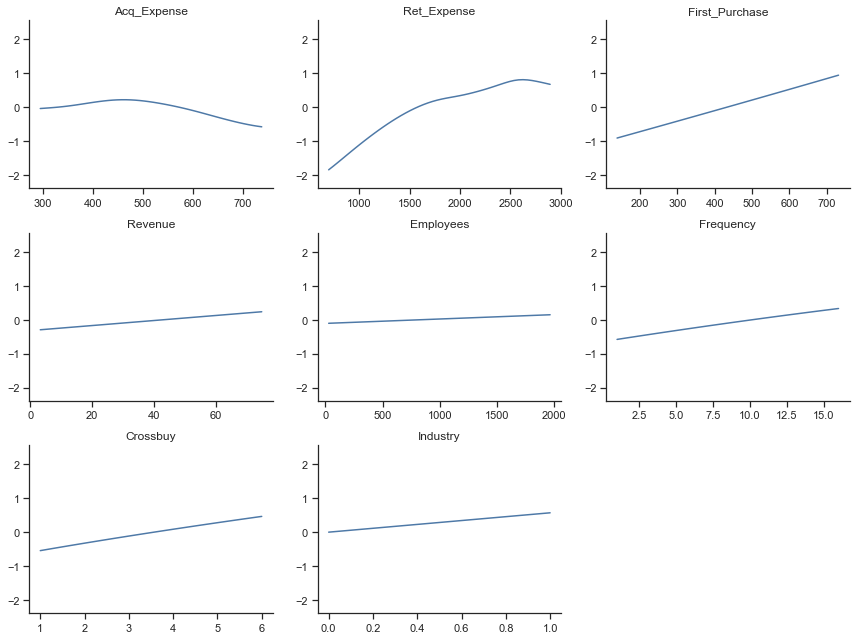

In [20]:
from statlearning import plot_additive_local_fit
plot_additive_local_fit(train[predictors], y_train, gam_local)
plt.show()

For the GAM based on regression splines, we implement a class that selects the degrees of freedom for each variable by backward selection. This is similar to one of the examples in the Elements of Statistical Learning textbook. Note then that we need to specify the maximum degrees of freedom for each predictor.

In [21]:
from statlearning import GAM_splines
max_dfs=[6,6,6,6,6,6,6,1]
gam_splines = GAM_splines(labels=predictors)
gam_splines.fit(X_train, y_train, max_dfs)

In [22]:
gam_splines.info()

Selected degrees of freedom (backward algorithm): 

Acq_Expense       4
Ret_Expense       2
First_Purchase    1
Revenue           1
Employees         0
Frequency         2
Crossbuy          1
Industry          1
dtype: int32


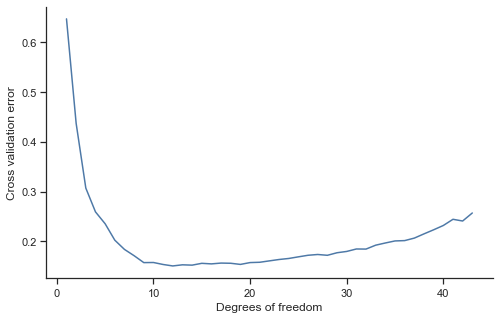

In [23]:
gam_splines.plot_cv()
plt.show()

## 7. Model Evaluation

The test results show that accounting for nonlinear effects leads to a substantial improvement in predictive accuracy relative to a linear regression. The GAM based on regression splines performs better than the model based on local regression in this case. 

In [25]:
ols = LinearRegression()
ols.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

# Initialise table
columns=['RMSE', 'R-Squared', 'MAE']
rows=['OLS', 'GAM (Splines)', 'GAM (Local)']
results =pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
methods = [ols, gam_splines, gam_local] 

# Computer test predictions and metrics
for i, method in enumerate(methods):
    y_pred = method.predict(X_test)
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i, 1] = r2_score(y_test, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_test, y_pred)

results.round(3)

,RMSE,R-Squared,MAE
OLS,0.539,0.661,0.415
GAM (Splines),0.414,0.800,0.289
GAM (Local),0.440,0.774,0.306


When you write a report for the assignment, you may want to transfer the table to Excel for formatting.  The best way to do it is as follows.

In [30]:
results.to_excel('results.xlsx')

This saves the data frame `results` to an excel file. You can then format the table and transfer it to your report.

In [26]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [27]:
from IPython.core.display import HTML
style = open('jstyle.css', "r").read()
HTML('<style>'+ style +'</style>')